<a href="https://colab.research.google.com/github/JO-HEEJIN/AI/blob/master/3D_Cardiac_Mesh_Analysis_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5768985%2F9483704%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240926%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240926T071620Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D883fb53e3e1416a5551cd0fc99c3c0d72eaf09b2fff796779385eb1ba041daeaa2ce8e049bee17a2f2231eb951fabe58235ddad88fa800372fc521bb8c717ac3e889234b2fb279f1f0f4734f1063f05b05fdf1a6c7c22922f2bfb01dee00060bd30ee3b0a3af1b05cff5f40a43748426c2688f9615fdaa0f2eca28d34304ee588edc22eaae86811baad7616e2aa7bbb4cafa72323bf716b674fa3cb52143f479b0298b00234c843c058a153be0a587a06fe3b65c63a22967927d11c1f8ee62b28f3a0bd2e5335e6f8b45afc767314ea379a2ae4e3ad2f33074f1ab84893f41a38ec0d5fc7020e753dc5fec2496a7547b0beb74dc0a72a202ddfc64787f420fe7'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


# 3D 재구성 위한 EDA

In [ ]:
# 필수 라이브러리 설치
!pip install numpy-stl
!pip install pydicom
!pip install matplotlib

## STL 파일 로드 및 시각화

Diastole Myocardium STL Files Visualization:


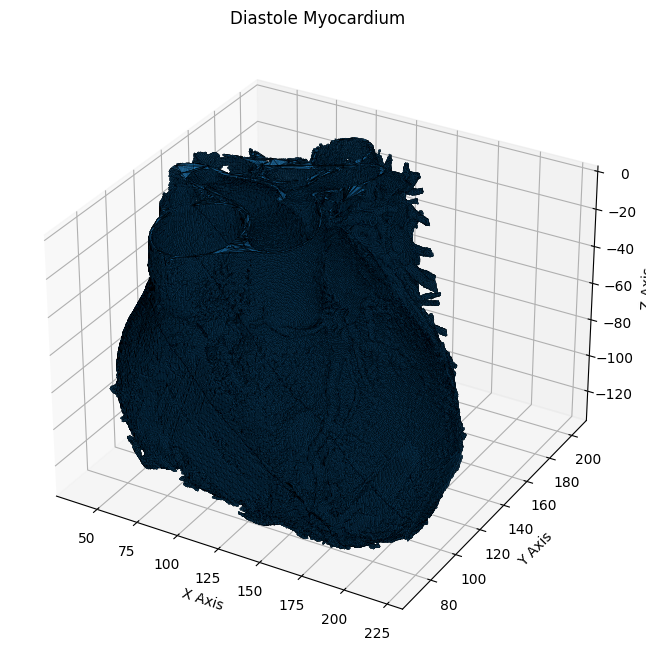

Systole Myocardium STL Files Visualization:


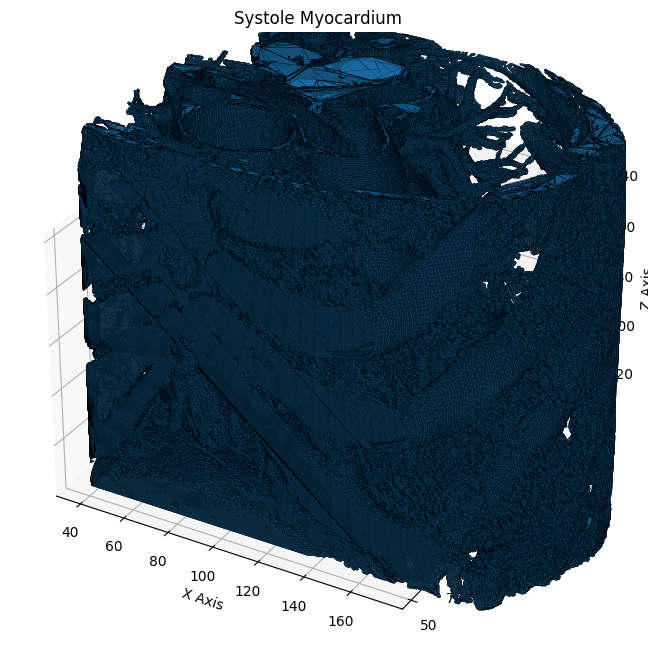

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from stl import mesh

# STL 파일 경로 설정
diastole_stl_dir = "/kaggle/input/dataset/diastole_Myocardium_stl/diastole_Myocardium_stl"
systole_stl_dir = "/kaggle/input/dataset/systole_Myocardium_stl/systole_Myocardium_stl"

# STL 파일을 로드하는 함수
def load_stl_files(directory):
    stl_files = []
    for filename in os.listdir(directory):
        if filename.endswith(".stl"):
            file_path = os.path.join(directory, filename)
            stl_files.append(mesh.Mesh.from_file(file_path))
    return stl_files

# 두 폴더에서 STL 파일 불러오기
diastole_meshes = load_stl_files(diastole_stl_dir)
systole_meshes = load_stl_files(systole_stl_dir)

# 시각화를 위한 함수
def plot_stl_meshes(meshes, title):
    figure = plt.figure(figsize=(10, 8))
    axes = figure.add_subplot(111, projection='3d')

    for heart_mesh in meshes:
        axes.add_collection3d(Poly3DCollection(heart_mesh.vectors, edgecolors='k', linewidths=0.1, alpha=0.6))

    # 스케일 설정
    axes.auto_scale_xyz(heart_mesh.points[:, 0], heart_mesh.points[:, 1], heart_mesh.points[:, 2])

    # 라벨 및 타이틀 설정
    axes.set_xlabel('X Axis')
    axes.set_ylabel('Y Axis')
    axes.set_zlabel('Z Axis')
    axes.set_title(title)

    plt.show()

# 각각의 STL 파일 시각화
print("Diastole Myocardium STL Files Visualization:")
plot_stl_meshes(diastole_meshes, 'Diastole Myocardium')

print("Systole Myocardium STL Files Visualization:")
plot_stl_meshes(systole_meshes, 'Systole Myocardium')


# STL_통계 및 형상 정보 분석

### 1. **STL 파일의 기초 통계 분석**
- **총 삼각형 면 개수**: 메쉬를 구성하는 삼각형의 개수를 분석.
- **점(vertex)의 개수**: 3D 객체의 모든 점(vertex)의 개수와 위치 범위를 분석.
- **삼각형 면적의 분포**: 각 삼각형 면의 면적을 계산하고 분포를 시각화.
- **STL 파일의 크기 분석**: 객체의 크기(가로, 세로, 높이)를 분석하여 데이터의 범위 파악.

### 2. **STL 파일의 형상 정보 분석**
- **3D 객체의 부피**: STL 파일로부터 객체의 부피를 계산.
- **표면적 계산**: STL 파일에서 모든 삼각형 면적을 합산하여 표면적을 계산.
- **3D 형상 비교**: 수축기와 이완기 데이터를 비교하여 형상 차이를 분석.

### 3. **3D 형상의 시각화 및 비교**
- **좌표축에 따른 형상 시각화**: 3D 공간에서의 형상을 다양한 각도에서 시각화하여 전체적인 형상 파악.
- **수축기와 이완기 간 형상 비교**: 두 STL 파일의 형상을 겹쳐 시각화하거나, 형상 변화를 3D에서 비교.

In [ ]:
import os
import numpy as np
from stl import mesh

# STL 파일의 기초 통계 및 형상 정보를 분석하는 함수
def analyze_stl_file(stl_mesh):
    # 삼각형 면의 총 개수
    num_triangles = len(stl_mesh.vectors)

    # 메쉬를 구성하는 모든 점(vertex) 추출
    vertices = np.unique(stl_mesh.vectors.reshape([stl_mesh.vectors.shape[0] * 3, 3]), axis=0)

    # 면적 계산
    def triangle_area(vectors):
        # 삼각형의 세 변 벡터를 구하고, 외적을 이용해 면적 계산
        a = vectors[1] - vectors[0]
        b = vectors[2] - vectors[0]
        cross_product = np.cross(a, b)
        area = np.linalg.norm(cross_product) / 2
        return area

    triangle_areas = np.array([triangle_area(tri) for tri in stl_mesh.vectors])
    total_surface_area = np.sum(triangle_areas)

    # STL 파일의 부피 계산
    def signed_volume_of_triangle(v0, v1, v2):
        return np.dot(v0, np.cross(v1, v2)) / 6

    volume = np.sum([signed_volume_of_triangle(stl_mesh.vectors[i, 0], stl_mesh.vectors[i, 1], stl_mesh.vectors[i, 2])
                     for i in range(num_triangles)])

    # 메쉬의 크기 계산 (최대/최소 좌표)
    min_coords = np.min(vertices, axis=0)
    max_coords = np.max(vertices, axis=0)
    dimensions = max_coords - min_coords

    # 결과 출력
    print(f"삼각형 면의 총 개수: {num_triangles}")
    print(f"고유 점(vertex) 개수: {len(vertices)}")
    print(f"총 표면적: {total_surface_area:.2f} square units")
    print(f"부피: {volume:.2f} cubic units")
    print(f"3D 객체의 크기 (x, y, z): {dimensions}")
    print(f"최소 좌표: {min_coords}, 최대 좌표: {max_coords}")

# 예시: diastole와 systole STL 파일 분석
diastole_stl_path = "/kaggle/input/dataset/diastole_Myocardium_stl/diastole_Myocardium_stl/10010_diastole_Myocardium_left.stl"
systole_stl_path = "/kaggle/input/dataset/systole_Myocardium_stl/systole_Myocardium_stl/10050_systole_Myocardium_left.stl"

# STL 파일 로드
diastole_mesh = mesh.Mesh.from_file(diastole_stl_path)
systole_mesh = mesh.Mesh.from_file(systole_stl_path)

# STL 파일 분석
print("Diastole STL 분석:")
analyze_stl_file(diastole_mesh)

print("\nSystole STL 분석:")
analyze_stl_file(systole_mesh)


Diastole STL 분석:
삼각형 면의 총 개수: 2753920
고유 점(vertex) 개수: 1369950
총 표면적: 209466.10 square units
부피: 312974.10 cubic units
3D 객체의 크기 (x, y, z): [182.95801 135.724   133.89601]
최소 좌표: [  37.604      67.768005 -133.89601 ], 최대 좌표: [220.56201 203.492     0.     ]

Systole STL 분석:


## DICOM 파일 로드 및 시각화

### 파일 경로 및 데이터 로드

In [ ]:
import os
import pydicom
import matplotlib.pyplot as plt

# 경로 정의
path1 = '/kaggle/input/dataset/Dicom 20181108 MR/Dicom 20181108 MR'
path2 = '/kaggle/input/dataset/Dicom S10050 systole/Dicom S10050 systole'
path3 = '/kaggle/input/dataset/S10010 diastole/S10010 diastole'

# DICOM 파일 로드 함수
def load_dicom_files(directory):
    dicom_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(".DCM") or file.startswith("I"):
                dicom_files.append(os.path.join(root, file))
    return dicom_files

# 각 경로의 DICOM 파일 리스트
dicom_files_20181108 = load_dicom_files(path1)
dicom_files_systole = load_dicom_files(path2)
dicom_files_diastole = load_dicom_files(path3)

print(f"Dicom 20181108 MR: {len(dicom_files_20181108)} files")
print(f"Dicom S10050 Systole: {len(dicom_files_systole)} files")
print(f"S10010 Diastole: {len(dicom_files_diastole)} files")


US1_J2KR.dcm:   0%|          | 38.0/154k [00:00<00:51, 3.01kB/s]
MR-SIEMENS-DICOM-WithOverlays.dcm:   0%|          | 125/511k [00:00<01:12, 7.06kB/s]
OBXXXX1A.dcm:   0%|          | 119/486k [00:00<01:02, 7.73kB/s]
US1_UNCR.dcm:   0%|          | 226/923k [00:00<01:32, 10.0kB/s]
color3d_jpeg_baseline.dcm:   0%|          | 1.50k/6.14M [00:00<03:44, 27.4kB/s]


Dicom 20181108 MR: 20 files
Dicom S10050 Systole: 354 files
S10010 Diastole: 354 files


### DICOM 파일 시각화

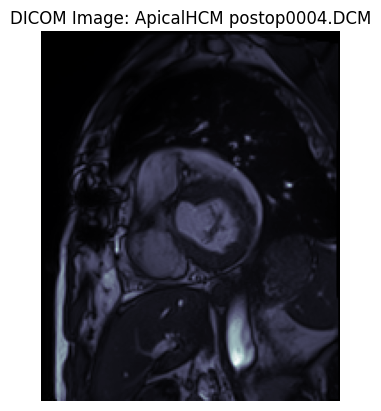

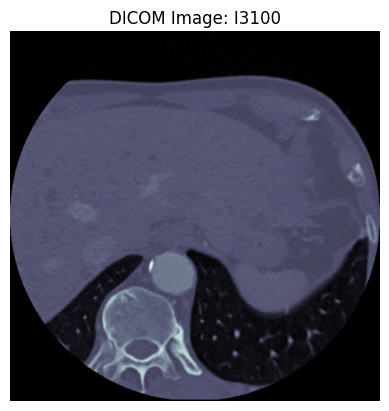

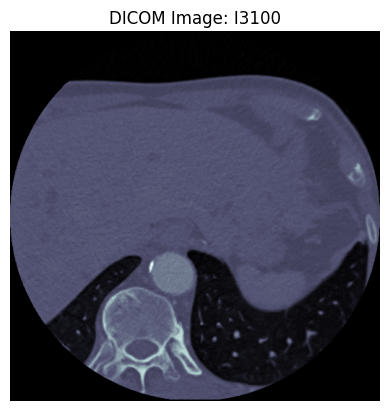

In [ ]:
def display_dicom_image(dicom_file):
    # DICOM 파일 읽기
    dicom_data = pydicom.dcmread(dicom_file)
    # DICOM 이미지 시각화
    plt.imshow(dicom_data.pixel_array, cmap=plt.cm.bone)
    plt.title(f"DICOM Image: {os.path.basename(dicom_file)}")
    plt.axis('off')
    plt.show()

# 예시로 첫 번째 파일 시각화
display_dicom_image(dicom_files_20181108[0])
display_dicom_image(dicom_files_systole[0])
display_dicom_image(dicom_files_diastole[0])


# DICOM_메타데이터 분석
#### 심장 움직임을 입체적으로 보여주기 위하여

In [ ]:
# DICOM 파일 로드
MR_dicom_file = pydicom.dcmread(dicom_files_20181108[0])
systole_dicom_file = pydicom.dcmread(dicom_files_systole[0])
diastole_dicom_file = pydicom.dcmread(dicom_files_diastole[0])

## MR

In [ ]:
# 메타데이터 출력
print(f"Dicom 20181108 MR: {MR_dicom_file}")

Dicom 20181108 MR: Dataset.file_meta -------------------------------
(0002,0000) File Meta Information Group Length  UL: 206
(0002,0001) File Meta Information Version       OB: b'\x00\x01'
(0002,0002) Media Storage SOP Class UID         UI: MR Image Storage
(0002,0003) Media Storage SOP Instance UID      UI: 1.3.12.2.1107.5.2.19.45792.2018110716224751247122811
(0002,0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002,0012) Implementation Class UID            UI: 1.2.410.200010.12.0.3.6.1
(0002,0013) Implementation Version Name         SH: 'INFINITT_361'
(0002,0016) Source Application Entity Title     AE: 'MSTZ420D'
-------------------------------------------------
(0008,0005) Specific Character Set              CS: 'ISO_IR 100'
(0008,0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'M', 'RETRO', 'NORM', 'DIS2D', 'FM1_3', 'FIL']
(0008,0012) Instance Creation Date              DA: '20181107'
(0008,0013) Instance Creation Time              TM


#### 1. **시간에 따른 심장 움직임 분석**
   - **Trigger Time (0018,1060)**: 심장이 수축하는 시간과 이완하는 시간을 추적하는 핵심 정보. 각 이미지가 심장의 어느 단계에서 촬영되었는지 확인해, 수축기와 이완기의 정확한 타이밍을 분석.
   - **Repetition Time (0018,0080)** 및 **Echo Time (0018,0081)**: 촬영 시 반복 시간과 에코 시간. 이를 바탕으로 심장의 전체 사이클에서 언제 이미지가 수집되었는지 추적.

#### 2. **심장의 3D 재구성을 위한 이미지 위치 및 방향**
   - **Image Position (0020,0032)**: 각 이미지의 좌표 정보. MRI 슬라이스가 공간에서 어떤 위치에 있는지를 알려주며, 3D 볼륨 재구성에 필수적.
   - **Image Orientation (0020,0037)**: 각 이미지의 방향 정보. 이를 통해 여러 슬라이스가 어떻게 배열되었는지 이해하고, 입체적인 구조로 재구성하는 데 사용.

#### 3. **슬라이스 두께 및 픽셀 간격**
   - **Slice Thickness (0018,0050)**: 슬라이스 두께. 이 값은 3D 재구성에서 각 슬라이스 간의 간격을 정의하는 데 사용. 두께가 두꺼우면 해상도가 떨어지고, 얇을수록 정밀한 3D 구조를 만들 수 있음.
   - **Pixel Spacing (0028,0030)**: 픽셀 간격. 각 이미지에서 한 픽셀이 실제 공간에서 얼마나 떨어져 있는지를 나타내며, 3D 볼륨의 해상도를 결정.

#### 4. **심장 모션 재구성을 위한 프레임 간 메타데이터**
   - **Cardiac Number of Images (0018,1090)**: 심장 주기에서 몇 개의 이미지가 수집되었는지. 이를 통해 각 심장 주기의 단계마다 몇 개의 이미지를 사용할 수 있는지 알 수 있으며, 이를 통해 수축과 이완 시의 심장 변화를 시간 순서대로 추적.
   - **Nominal Interval (0018,1062)**: 두 이미지 사이의 시간 간격. 심장의 주기적인 움직임을 재현할 때 중요한 정보로 사용됨.

#### 5. **심장 3D 모델 재구성 및 애니메이션**
   - **Pixel Data (7FE0,0010)**: 실제 MRI 이미지 데이터. 이를 사용해 2D 이미지를 3D 볼륨으로 변환한 후, 시간 순서대로 재구성하여 심장의 움직임을 입체적으로 표현.
   - **Window Center (0028,1050) 및 Window Width (0028,1051)**: 이미지의 밝기 및 대비 조정. 이 값을 적절히 설정하여, 심장 내부 구조를 명확히 구분할 수 있게 함.

#### 요약
시간에 따른 심장 움직임 추적, 3D 재구성을 위한 슬라이스 위치 및 방향 정보, 그리고 이미지 해상도를 결정하는 슬라이스 두께와 픽셀 간격은 움직이는 심장을 입체적으로 표현하기 위한 필수 요소.

In [ ]:
print(f"Dicom S10050 Systole: {systole_dicom_file}")

Dicom S10050 Systole: Dataset.file_meta -------------------------------
(0002,0000) File Meta Information Group Length  UL: 198
(0002,0001) File Meta Information Version       OB: b'\x00\x01'
(0002,0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002,0003) Media Storage SOP Instance UID      UI: 1.3.46.670589.33.1.63700093337291876900001.5049746973436792333
(0002,0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002,0012) Implementation Class UID            UI: 1.3.46.670589.50.1.10.0
(0002,0013) Implementation Version Name         SH: 'PORTAL_10.0'
-------------------------------------------------
(0008,0005) Specific Character Set              CS: 'ISO_IR 100'
(0008,0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL']
(0008,0012) Instance Creation Date              DA: '20190730'
(0008,0013) Instance Creation Time              TM: '142217.292'
(0008,0016) SOP Class UID                       UI: CT Image Storage
(0008,0

## CT_systole

### 1. **촬영 기기 및 프로토콜**
   - **Modality (0008,0060)**: 'CT' (컴퓨터 단층 촬영). MRI가 아닌 CT를 사용하여 심장 구조를 촬영. 이와 같은 방식으로 촬영된 이미지는 고해상도 3D 구조 분석에 사용.
   - **Manufacturer (0008,0070)** 및 **Model Name (0008,1090)**: 'Philips iCT 256'. 256채널 CT 스캐너를 사용. 256개의 슬라이스를 동시에 촬영하여 고속 및 고해상도 이미지를 생성.
   - **Protocol Name (0018,1030)**: 'CTA Coronary Aorta /Cardiac'. 심장과 대동맥을 집중적으로 스캔하는 프로토콜 사용. 이를 통해 주로 혈관과 심장 벽의 구조적 상태 분석 가능.

### 2. **심장 모션 분석 관련 주요 정보**
   - **Acquisition Type (0018,9302)**: 'SPIRAL'. 나선형 스캔 방식을 사용하여 연속적인 심장 이미지를 얻음. 이는 빠르게 움직이는 심장 데이터를 고해상도로 촬영하는 데 적합.
   - **Revolution Time (0018,9305)**: 0.33초. CT 기기가 한 바퀴를 도는 데 걸리는 시간으로, 빠른 심장박동을 추적하는 데 적합.
   - **Gating Delay (01F1,1041)**: '45%'. 심장의 주기에서 45% 지점에서 촬영된 이미지. 이는 수축기의 중간 단계에서 심장이 어떻게 움직이는지 분석하는 데 사용.

### 3. **3D 재구성 및 슬라이스 정보**
   - **Slice Thickness (0018,0050)**: 0.9mm. 얇은 슬라이스로 심장의 세부 구조를 고해상도로 재구성할 수 있음.
   - **Spacing Between Slices (0018,0088)**: 0.45mm. 슬라이스 간 간격이 좁아, 더 정밀한 3D 볼륨 재구성이 가능.
   - **Image Position (0020,0032)** 및 **Image Orientation (0020,0037)**: 슬라이스의 위치와 방향 정보. 이를 바탕으로 각각의 이미지를 3D 공간에서 정확하게 배치하여 심장의 입체적인 형태를 재구성.

### 4. **픽셀 정보 및 이미지 해상도**
   - **Pixel Spacing (0028,0030)**: [0.449, 0.449]mm. 이미지의 각 픽셀이 실제 공간에서 얼마나 떨어져 있는지를 나타냄. 해상도가 높아 심장 구조를 더욱 정밀하게 관찰 가능.
   - **Rows (0028,0010)** 및 **Columns (0028,0011)**: 512x512. 각 슬라이스의 해상도로, 고해상도의 2D 이미지를 제공하며 이를 통해 3D로 재구성할 때 높은 정확도를 보장.

### 5. **심장 데이터의 촬영 조건**
   - **Contrast/Bolus Agent (0018,0010)**: 'XENETIX350-200ml'. 조영제를 사용하여 혈관과 심장 내 구조를 더 명확히 시각화.
   - **Contrast Flow Rate (0018,1046)**: 조영제 주입 속도는 없지만, 조영제 농도가 '350'으로 높은 농도로 주입됨. 이를 통해 혈관과 심장의 경계를 선명하게 확인 가능.

### 6. **움직이는 심장 3D 재구성**
   - **Pixel Data (7FE0,0010)**: 실제 이미지 데이터. 수집된 모든 슬라이스 데이터를 이용하여 심장의 수축과 이완 시 움직임을 3D로 재구성할 수 있는 핵심 정보.
   - **Reconstruction Diameter (0018,1100)**: '230mm'. 재구성된 이미지의 직경. 심장의 크기와 해부학적 구조를 적절히 반영할 수 있음.

### 결론
- 나선형 CT 촬영 방식(Spiral)과 고해상도 데이터를 바탕으로 심장의 움직임을 입체적으로 분석 가능.
- 3D 재구성을 위한 슬라이스 두께와 픽셀 간격 정보가 충분히 세밀하여 정확한 심장 모션 분석에 적합.
- Gating Delay 정보를 통해 수축기 특정 시점의 심장 움직임을 포착하여 입체적으로 시각화 가능.

In [ ]:
print(f"S10010 Diastole: {diastole_dicom_file}")

S10010 Diastole: Dataset.file_meta -------------------------------
(0002,0000) File Meta Information Group Length  UL: 198
(0002,0001) File Meta Information Version       OB: b'\x00\x01'
(0002,0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002,0003) Media Storage SOP Instance UID      UI: 1.3.46.670589.33.1.63700093180851929000001.5400848675401253742
(0002,0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002,0012) Implementation Class UID            UI: 1.3.46.670589.50.1.10.0
(0002,0013) Implementation Version Name         SH: 'PORTAL_10.0'
-------------------------------------------------
(0008,0005) Specific Character Set              CS: 'ISO_IR 100'
(0008,0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL']
(0008,0012) Instance Creation Date              DA: '20190730'
(0008,0013) Instance Creation Time              TM: '141940.857'
(0008,0016) SOP Class UID                       UI: CT Image Storage
(0008,0018) 

## CT_distole

### 1. **촬영 기기 및 프로토콜**
   - **Modality (0008,0060)**: 'CT' (컴퓨터 단층 촬영). 심장 및 혈관 구조를 촬영하는 데 사용된 CT.
   - **Manufacturer (0008,0070) 및 Model Name (0008,1090)**: 'Philips iCT 256'. 256채널 CT 스캐너 사용. 고해상도 및 빠른 심장 촬영에 적합한 기기.
   - **Protocol Name (0018,1030)**: 'CTA Coronary Aorta /Cardiac'. 심장과 대동맥을 중점으로 촬영. 이를 통해 혈관의 구조적 이상 및 심장의 형태 분석.

### 2. **심장 모션 분석 관련 주요 정보**
   - **Acquisition Type (0018,9302)**: 'SPIRAL'. 나선형 스캔 방식. 연속적인 촬영으로 심장 데이터를 시간 흐름에 따라 수집하여 입체적으로 재구성 가능.
   - **Gating Delay (01F1,1041)**: '75%'. 심장 주기의 75% 지점에서 촬영된 이미지. 이는 이완기의 중간 단계에서 심장의 움직임을 보여줌.

### 3. **3D 재구성을 위한 슬라이스 정보**
   - **Slice Thickness (0018,0050)**: 0.9mm. 얇은 슬라이스를 통해 심장의 세부 구조를 고해상도로 재구성 가능.
   - **Spacing Between Slices (0018,0088)**: 0.45mm. 슬라이스 간 간격이 좁아, 더 세밀한 3D 볼륨 재구성 가능.
   - **Image Position (0020,0032) 및 Image Orientation (0020,0037)**: 슬라이스의 위치와 방향 정보. 이를 사용해 슬라이스 이미지를 3D 공간에서 정확하게 배열하여 심장의 입체적인 모양을 재구성.

### 4. **픽셀 정보 및 이미지 해상도**
   - **Pixel Spacing (0028,0030)**: [0.449, 0.449]mm. 각 픽셀이 실제 공간에서 차지하는 크기. 이를 통해 이미지의 해상도를 알 수 있으며, 3D 재구성 시 중요한 역할.
   - **Rows (0028,0010) 및 Columns (0028,0011)**: 512x512. 고해상도의 2D 이미지로, 이를 통해 3D 재구성 시 높은 정확도를 보장.

### 5. **조영제 및 방사선 정보**
   - **Contrast/Bolus Agent (0018,0010)**: 'XENETIX350-200ml'. 조영제를 사용하여 심장 및 혈관의 경계가 더 명확하게 나타남.
   - **CTDIvol (0018,9345)**: 35.2. 방사선 노출량을 나타내며, 고해상도의 이미지를 얻기 위한 방사선량.

### 6. **움직이는 심장 3D 재구성**
   - **Pixel Data (7FE0,0010)**: 실제 이미지 데이터. 이 데이터를 기반으로 수집된 슬라이스들을 3D 볼륨으로 변환하여 심장의 움직임을 입체적으로 시각화 가능.
   - **Revolution Time (0018,9305)**: 0.33초. CT 기기가 한 바퀴를 도는 데 걸리는 시간. 이를 통해 심장의 빠른 움직임을 추적 가능.

### 결론
- 이완기 상태의 심장을 정확하게 재현할 수 있는 고해상도 데이터. 슬라이스 간격이 매우 좁고 픽셀 해상도가 높아, 입체적으로 심장의 이완기 중 움직임을 세밀하게 재구성 가능.